<a href="https://colab.research.google.com/github/lamld203844/Biomedical-Segmentation/blob/main/fetch_kaggle_data_train_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle --version
!kaggle datasets download -d ryanlliu/jnu-ifm-for-segment-pubic-symphysis-fetal-head
!unzip -q /content/jnu-ifm-for-segment-pubic-symphysis-fetal-head.zip

Kaggle API 1.5.16
100% 1.67G/1.67G [01:26<00:00, 26.7MB/s]
100% 1.67G/1.67G [01:26<00:00, 20.7MB/s]


In [2]:
!pip install -q watermark lightning

%load_ext watermark
%watermark -v -p pandas,numpy,matplotlib,seaborn,torch,torchvision,PIL,cv2,tensorboard,lightning --conda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.3 MB/s eta 0:00:00
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pandas     : 1.5.3
numpy      : 1.23.5
matplotlib : 3.7.1
seaborn    : 0.13.1
torch      : 2.1.0+cu121
torchvision: 0.16.0+cu121
PIL        : 9.4.0
cv2        : 4.8.0
tensorboard: 2.15.1
lightning  : 2.2.0

conda environment: n/a



In [3]:
import random

from PIL import Image
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import lightning as L
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

L.pytorch.seed_everything(123)

INFO: Seed set to 123
INFO:lightning.fabric.utilities.seed:Seed set to 123


123

# Prepare dataset


In [4]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
b_sz = 8 # batch size

# define SEGMENTATION dataset class
class SegmentationDataset(Dataset):
    def __init__(self, dataset_path, mask_dir, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform
        self.dataset_path = dataset_path
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = f'{self.dataset_path}/image/{img_name}'
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        mask_name = self.masks[idx]
        mask_path = f'{self.dataset_path}/{mask_dir}/{mask_name}'
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # read mask in grayscale

        # loss func: crossentropy just accept: 0, 1, 2, ... like indices
        mask[mask == 7] = 1 # convert mask value 7(SP) -> 1
        mask[mask == 8] = 2 # convert mask value 8(head) -> 2

        mask = Image.fromarray(mask)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # convert to long tensor
        # and .squeeze() > removes redundant dimensions (1, rz, rz) > (rz, rz)
        # * 255 to avoid = 0 (due to long()), since being scaling [0, 1] of ToTensor()
        mask = (mask * 255).long().squeeze()

        return image, mask

t_test = T.Compose([
        T.CenterCrop((1024, 1024)),
        T.Resize(size=(128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.ToTensor(),
])

t_train = T.Compose([
        T.CenterCrop((1024, 1024)),
        T.Resize(size=(128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=20),
        T.ToTensor(),
        T.RandomErasing(p=0.2),
])


def get_dataset_loaders(dataset_path, mask_dir):
    '''
    input:
        - dataset_path,
        - mask_dir: subdir in dataset_path i.e 'mask' or 'enhance_mask'
    output:
        - train_loader, val_loader, test_loader
    '''
    ## GET IMAGE AND MASK PATHS
    img_paths = os.listdir(f'{dataset_path}/image')
    mask_paths = os.listdir(f'{dataset_path}/{mask_dir}')

    imgs = [img.replace("_mask", "") for img in mask_paths] # Mapping 1-1 between mask and image

    ## TEST-TRAIN SPLITTING ratio 9(9-1)-1
    train_img, test_img, train_mask, test_mask = train_test_split(imgs,
                                                                  mask_paths,
                                                                  test_size = 0.1,
                                                                  random_state=123)
    train_img, val_img, train_mask, val_mask = train_test_split(train_img,
                                                                train_mask,
                                                                test_size = 0.1,
                                                                random_state=123)

    ## DEFINE DATASET
    train_set = SegmentationDataset(
        dataset_path,
        mask_dir,
        train_img,
        train_mask,
        transform=t_train)
    val_set = SegmentationDataset(
        dataset_path,
        mask_dir,
        val_img,
        val_mask,
        transform=t_test)
    test_set = SegmentationDataset(
        dataset_path,
        mask_dir,
        test_img,
        test_mask,
        transform=t_test)

    ## DEFINE DATALOADER
    train_loader = DataLoader(dataset=train_set, batch_size=b_sz, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_set, batch_size=b_sz, shuffle=True, num_workers=2)
    test_loader = DataLoader(dataset=test_set, batch_size=b_sz, shuffle=True, num_workers=2)

    return train_loader, val_loader, test_loader

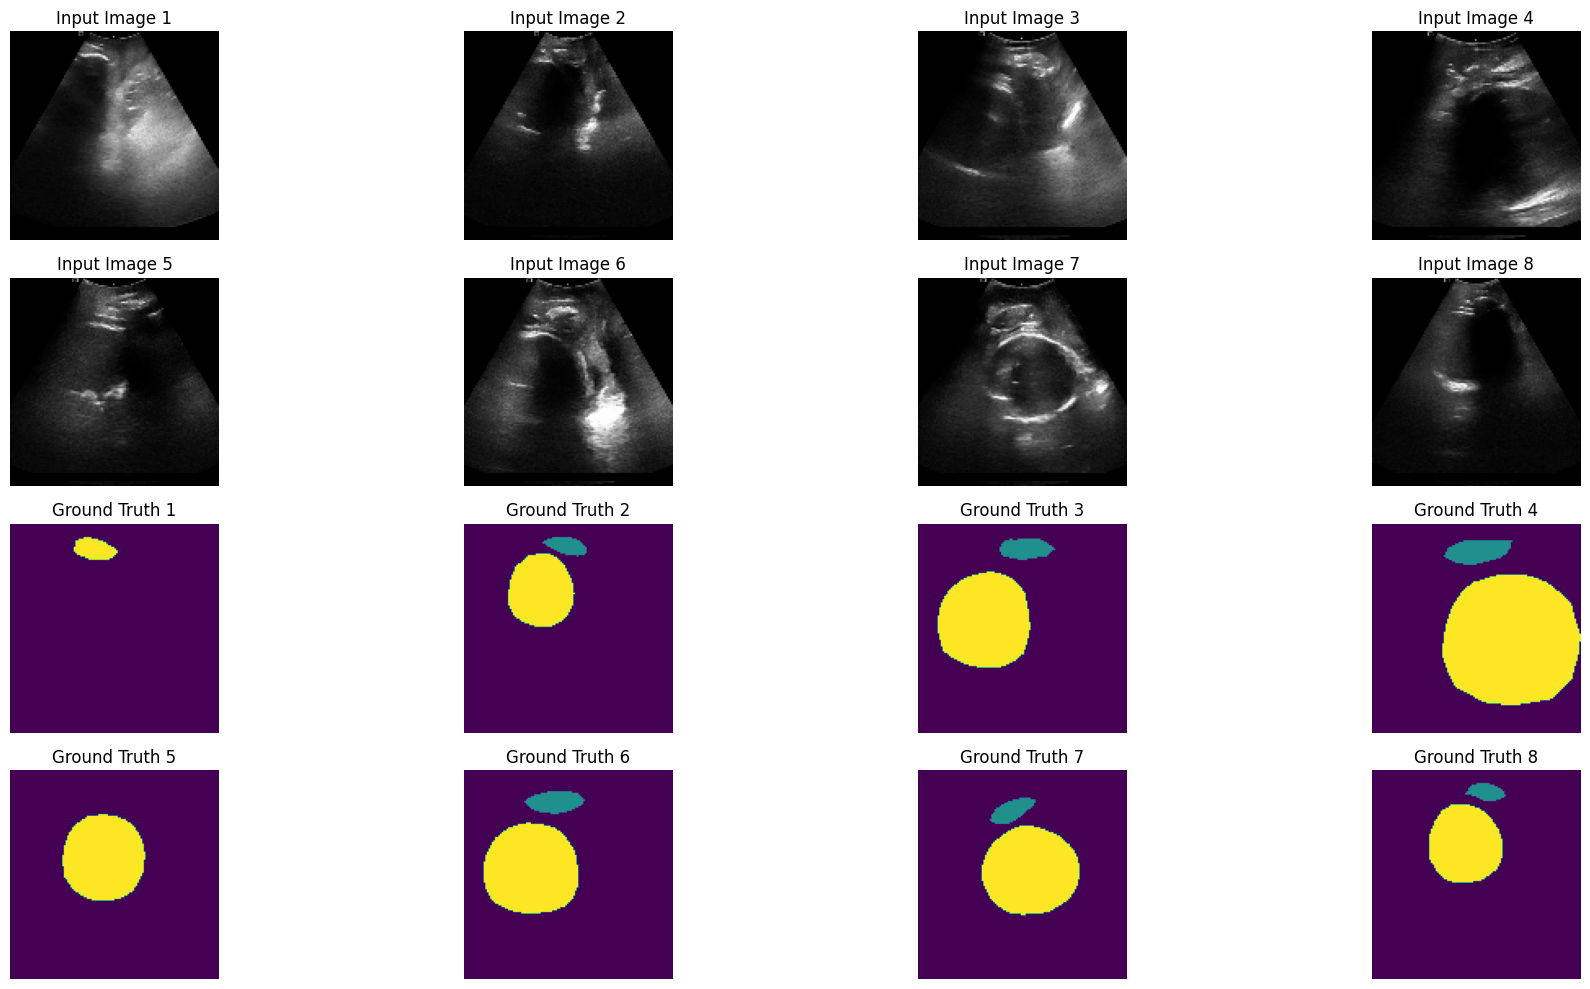

In [5]:
dataset_path = '/content/dataset'
mask_dir = 'mask' # type of mask set: "mask" or "enhance mask"
train_loader, val_loader, test_loader = get_dataset_loaders(dataset_path, mask_dir)

def visualize(loader, n=b_sz):
    # Get a batch of images and masks from the loader
    images, masks = next(iter(loader))

    # Plot the images and masks individually
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
    axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array

    for i in range(n):
        # Input Image
        axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i].set_title(f'Input Image {i+1}')
        axes[i].axis('off')  # Hide axis labels and ticks

        # Ground Truth
        axes[i+n].imshow(masks[i].squeeze(), cmap='viridis')
        axes[i+n].set_title(f'Ground Truth {i+1}')
        axes[i+n].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

visualize(val_loader, b_sz)


# Lightning module

In [6]:
criterion = nn.CrossEntropyLoss()

class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = criterion(logits, true_labels)
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = criterion(logits, true_labels)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

# Training

In [7]:
!pip install -q segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.1 MB/s eta 0:00:00


In [8]:
# Import the library
import segmentation_models_pytorch as smp

## MODEL
pytorch_model = smp.Unet(
    encoder_name="resnet34", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet", # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1, # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3, # model output channels (number of classes in your dataset)
)

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 35.5MB/s]


In [9]:
## Dataloader
dataset_path = '/content/dataset'
mask_dir = 'mask' # type of mask set: "mask" or "enhance mask"
train_loader, val_loader, test_loader = get_dataset_loaders(dataset_path, mask_dir)

## Trainer
trainer = L.Trainer(
    max_epochs=5,
    accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
    devices="auto",  # Uses all available GPUs if applicable
)

trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.722    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Testing

In [10]:
def pixel_accuracy(output, mask):
    '''
    args:
        logits output, mask
    output:
        accuracy
    '''
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

# smooth to avoid divide to 0
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=3):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): # loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)



In [11]:
from tqdm.auto import tqdm

def compute_accuracy(model, loader, device=None, loader_type="Test"):

    if device is None:
        device = torch.device("cpu")
    model = model.eval()
    model.to(device)

    test_loss = 0.0
    test_iou = 0.0
    test_accuracy = 0.0

    with torch.no_grad():
        for idx, (features, labels) in enumerate(tqdm(loader)):
            features, labels = features.to(device), labels.to(device)

            logits = model(features)
            loss = criterion(logits, labels)

            # Calculate metrics
            test_iou += mIoU(logits, labels)
            test_accuracy += pixel_accuracy(logits, labels)

            test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader)
    average_test_iou = test_iou / len(test_loader)
    average_test_accuracy = test_accuracy / len(test_loader)

    print(
        f"{loader_type} Loss: {average_test_loss:.4f}"
        f" | {loader_type} mIoU: {average_test_iou:.4f}"
        f" | {loader_type} Accuracy: {average_test_accuracy:.4f}"
    )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_acc = compute_accuracy(pytorch_model, train_loader, device, "Train")
val_acc = compute_accuracy(pytorch_model, val_loader, device, "Validation")
test_acc = compute_accuracy(pytorch_model, test_loader, device)

  0%|          | 0/630 [00:00<?, ?it/s]

Train Loss: 1.4816 | Train mIoU: 4.5563 | Train Accuracy: 7.3438


  0%|          | 0/71 [00:00<?, ?it/s]

Validation Loss: 0.1535 | Validation mIoU: 0.5432 | Validation Accuracy: 0.8271


  0%|          | 0/78 [00:00<?, ?it/s]

Test Loss: 0.1749 | Test mIoU: 0.5969 | Test Accuracy: 0.9060


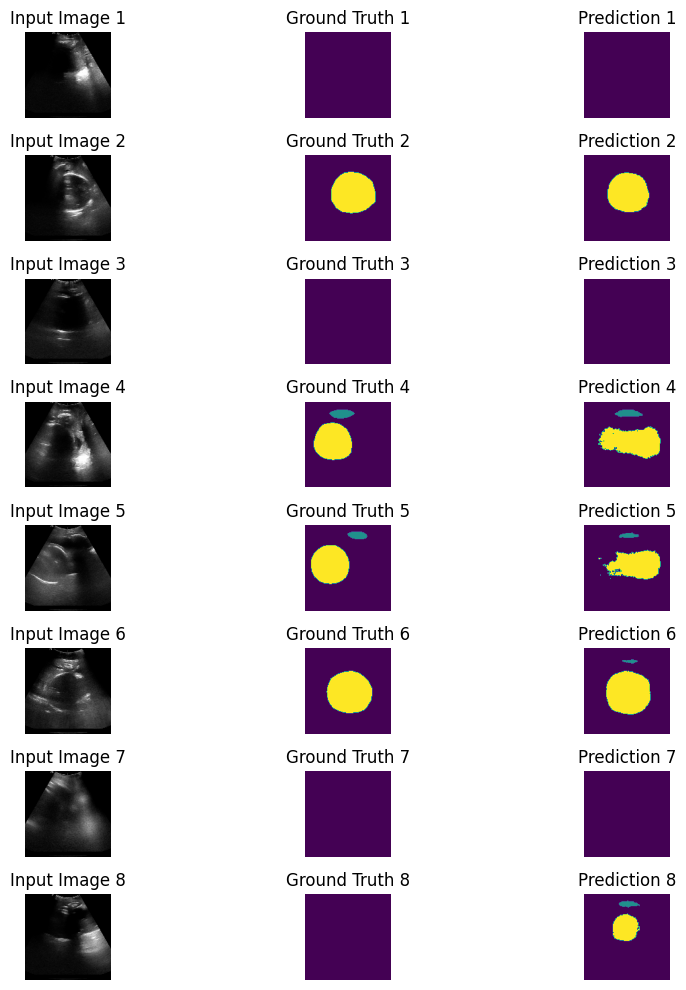

In [12]:
def visualize_full(loader, model):
    # Get a batch of images and masks from the loader
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)

    # Get model predictions
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        preds = model(images)

    batch_size = images.size(0)

    # Plot the images, masks, and predictions individually
    fig, axes = plt.subplots(nrows=batch_size, ncols=3, figsize=(10, 10))  # Adjust the number of rows and columns here
    axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array

    for i in range(batch_size):
        # Input Image
        axes[3*i].imshow(images[i].cpu().permute(1, 2, 0), cmap='gray')
        axes[3*i].set_title(f'Input Image {i+1}')
        axes[3*i].axis('off')  # Hide axis labels and ticks

        # Ground Truth
        axes[3*i+1].imshow(masks[i].cpu().squeeze(), cmap='viridis')
        axes[3*i+1].set_title(f'Ground Truth {i+1}')
        axes[3*i+1].axis('off')

        # Model Prediction
        axes[3*i+2].imshow(torch.argmax(preds[i], dim=0).cpu().squeeze(), cmap='viridis')
        axes[3*i+2].set_title(f'Prediction {i+1}')
        axes[3*i+2].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

visualize_full(test_loader, pytorch_model)